#**Import libraries**

In [170]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,CategoricalNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve

#**Concatinate Train & Test files**

In [171]:
# read the train csv file 
path1= '/content/train_new.csv'
df1= pd.read_csv(path1)

# read the test csv file 
path2= '/content/test_new.csv'
df2= pd.read_csv(path2)
df2['rating']= 0               # add rating column to test file with value 0; to adjust the dimension of two files

#concatenate the two files in one variable(df)
df= pd.concat([df1,df2], ignore_index=True, sort=False)

#**Get quick look on the dataset** 

In [172]:
# display the first 5 rows of data
df.head()

,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,theme,crawl_month,id
0,8.00,7,EUR,10000,1,4.0,1670,0,0,0,0,"Summer,soildcolor,Plus Size,Tank,camisole,Tops...",yellow,M,50,Livraison standard,3,0,30,50,NaN,NaN,CN,keepahorse,keepahorse,"88 % avis positifs (66,644 notes)",66644,4.137582,577fb2b368116418674befd9,1,https://s3-us-west-1.amazonaws.com/sweeper-pro...,summer,2020-08,272
1,8.00,7,EUR,1000,0,4.0,843,1,1,0,0,"bathing suit,Plus Size,bikini set,sexy swimsui...",black,L,50,Livraison standard,3,0,37,50,NaN,NaN,CN,shanghaimingqidianqikejiyouxiangongsi,上海铭启电气科技有限公司,"91 % avis positifs (25,752 notes)",25752,4.256873,566a3ef17233ff2686443082,0,NaN,summer,2020-08,1515
2,6.00,34,EUR,100,0,4.0,10,0,0,0,0,"Summer,Vest,momshirt,Get,summer t-shirts,funny...",white,L,50,Livraison standard,2,0,41,50,NaN,NaN,CN,zhaodongmei,zhaodongmei,"83 % avis positifs (3,897 notes)",3897,3.928920,5aacd6c1ccf0c83e5a6f3de0,0,NaN,summer,2020-08,940
3,4.67,4,EUR,100,1,3.0,82,0,0,0,0,"Summer,Shorts,pants,Beach,Plus Size,beachpant,...",lakeblue,XS,5,Livraison standard,1,0,25,50,NaN,NaN,CN,pookie0331,pookie0331,"87 % avis positifs (7,497 notes)",7497,4.079365,583141fbfef4094e51453d9b,0,NaN,summer,2020-08,309
4,8.00,11,EUR,1000,0,4.0,127,0,0,0,0,"Summer,Floral print,women dresses,fashion dres...",apricot,S,50,Livraison standard,3,0,15,50,1.0,Quantité limitée !,CN,shitongyi12683626,shitongyi12683626,91 % avis positifs (173 notes),173,4.306358,5d3bc9f8e13a7e654424a4cb,0,NaN,summer,2020-08,226


In [173]:
# shape of data
df.shape

(1573, 34)

In [174]:
# Calculate count, mean, std, min, 25%, 50%, 75%, max values for each column (statistical summary). 
round(df.describe())

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,id
count,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,1573.0,473.0,1573.0,1573.0,1573.0,1573.0
mean,8.0,23.0,4339.0,0.0,3.0,890.0,0.0,0.0,0.0,0.0,33.0,2.0,0.0,40.0,50.0,1.0,26496.0,4.0,0.0,786.0
std,4.0,30.0,9357.0,0.0,2.0,1984.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,20.0,3.0,0.0,78474.0,0.0,0.0,454.0
min,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,1.0,0.0,2.0,0.0,0.0
25%,6.0,7.0,100.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,31.0,50.0,1.0,1987.0,4.0,0.0,393.0
50%,8.0,10.0,1000.0,0.0,4.0,150.0,0.0,0.0,0.0,0.0,50.0,2.0,0.0,40.0,50.0,1.0,7936.0,4.0,0.0,786.0
75%,11.0,26.0,5000.0,1.0,4.0,855.0,0.0,0.0,0.0,0.0,50.0,3.0,0.0,43.0,50.0,1.0,24564.0,4.0,0.0,1179.0
max,49.0,252.0,100000.0,1.0,6.0,20744.0,3.0,1.0,1.0,1.0,50.0,12.0,1.0,140.0,50.0,1.0,2174765.0,5.0,1.0,1572.0


**Observations** 

There is a difference between mean and median in some columns so the values are not normally distributed:

* The distribution is positively skewed **(Mean > Median)** in: 

    >retail_price, units_sold,rating_count, merchant_rating_count 

* The distribution is negatively skewed **(Mean < Median)** in: 
    >rating, product_variation_inventory

* The distribution is normally **(Mean = Median)** in other columns


In [175]:
# data info (id,name,count,dtype of each feature)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         1573 non-null   float64
 1   retail_price                  1573 non-null   int64  
 2   currency_buyer                1573 non-null   object 
 3   units_sold                    1573 non-null   int64  
 4   uses_ad_boosts                1573 non-null   int64  
 5   rating                        1573 non-null   float64
 6   rating_count                  1573 non-null   int64  
 7   badges_count                  1573 non-null   int64  
 8   badge_local_product           1573 non-null   int64  
 9   badge_product_quality         1573 non-null   int64  
 10  badge_fast_shipping           1573 non-null   int64  
 11  tags                          1573 non-null   object 
 12  product_color                 1532 non-null   object 
 13  pro

**Observation #1:** Columns with object datatype can be converted to 'int' for convenience.

**Observation #2:** Some columns containing missing values.

In [176]:
# display column names that contain NaN values
df.columns[df.isna().any()].tolist()

#if we want to display them as dataframe 
#pd.DataFrame(df.columns[df.isna().any()], columns=['Features contain NaN values'])

['product_color',
 'product_variation_size_id',
 'has_urgency_banner',
 'urgency_text',
 'origin_country',
 'merchant_name',
 'merchant_info_subtitle',
 'merchant_profile_picture']

**Observation:** The above 8 columns contain missing values.

In [177]:
# display the correlation between the features and the output(rating)
df.corr().loc['rating']

price                           0.047734
retail_price                    0.039670
units_sold                      0.030689
uses_ad_boosts                 -0.011796
rating                          1.000000
rating_count                    0.024608
badges_count                    0.088523
badge_local_product             0.010393
badge_product_quality           0.110506
badge_fast_shipping            -0.002165
product_variation_inventory    -0.008380
shipping_option_price           0.043286
shipping_is_express             0.018891
countries_shipped_to            0.007232
inventory_total                -0.008199
has_urgency_banner                   NaN
merchant_rating_count           0.017720
merchant_rating                 0.072626
merchant_has_profile_picture    0.054426
id                             -0.031826
Name: rating, dtype: float64

**Observation:** The NaN, in case of **'has_urgency_banner'** column,is interpreted as no correlation between the two variables.

In [178]:
# display the number of unique values for each column   
df.nunique()

price                            127
retail_price                     104
currency_buyer                     1
units_sold                        15
uses_ad_boosts                     2
rating                             7
rating_count                     761
badges_count                       4
badge_local_product                2
badge_product_quality              2
badge_fast_shipping                2
tags                            1230
product_color                    101
product_variation_size_id        106
product_variation_inventory       48
shipping_option_name              15
shipping_option_price              8
shipping_is_express                2
countries_shipped_to              94
inventory_total                   10
has_urgency_banner                 1
urgency_text                       2
origin_country                     6
merchant_title                   958
merchant_name                    957
merchant_info_subtitle          1058
merchant_rating_count            917
m

**Observation:** There are some columns that have only one unique value, we must drop them later as they won't affect our classification

In [179]:
# columns that contain one unique value
df.columns[df.nunique()==1].tolist()

['currency_buyer', 'has_urgency_banner', 'theme', 'crawl_month']

**Observation:** The above 4 columns have only one unique value, so have no effect on our classification. So I should drop them.

In [180]:
#Count the number of null values in each column
df.isnull().sum()

price                              0
retail_price                       0
currency_buyer                     0
units_sold                         0
uses_ad_boosts                     0
rating                             0
rating_count                       0
badges_count                       0
badge_local_product                0
badge_product_quality              0
badge_fast_shipping                0
tags                               0
product_color                     41
product_variation_size_id         14
product_variation_inventory        0
shipping_option_name               0
shipping_option_price              0
shipping_is_express                0
countries_shipped_to               0
inventory_total                    0
has_urgency_banner              1100
urgency_text                    1100
origin_country                    17
merchant_title                     0
merchant_name                      4
merchant_info_subtitle             1
merchant_rating_count              0
m

**Observasions**

* Product color and size variation has 29 and 12 null values respectively. Perhaps this products have no variations?

* Origin countries have 12 null values. I might replace this with the mode if necessary.

* Surprisingly there are 4 missing merchant names.

* There are 924 missing merchant profile pictures. I am expecting this to match with 'zeros' in 'merchant_has_profile_picture'.

* the 3 columns 'has_urgency_banner','urgency_text','merchant_profile_picture' seem to have many missing values. I might drop them if i found them are not necessary.

In [181]:
#display the uique values with its count in the column
df['has_urgency_banner'].value_counts()

1.0    473
Name: has_urgency_banner, dtype: int64

In [182]:
#display the uique values with its count in the column
df['urgency_text'].value_counts()

Quantité limitée !                  472
Réduction sur les achats en gros      1
Name: urgency_text, dtype: int64

In [183]:
#display the uique values with its count in the column
df['merchant_profile_picture'].value_counts()

https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_5acaf29d5ebcfd72403106a8.jpg    12
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_5533c83986ff95173dc017d0.jpg     8
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_58ad449708de0c6dc59d9e06.jpg     6
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_55c8a4c33a698c6010edcd9e.jpg     6
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_577fb2b368116418674befd9.jpg     5
                                                                                                       ..
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_58a3f270e269ee522580e6bb.jpg     1
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_547465748edcfa6ceab14f70.jpg     1
https://s3-us-west-1.amazonaws.com/sweeper-production-merchantimage/dp_56db028b3a9cb801c374b3c6.jpg     1
https://s3-us-west-1.amazonaws.com/sweeper-pro

**Observation:** The above 3 columns have only one unique value & many missing data. So I should drop them

*Check the features which are highly correlated*

In [184]:
#Creating the Correlation matrix
cor_matrix = df.corr().abs()

#Select the upper triangular
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

#Select the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'to_drop'
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(); print(to_drop)


[]


**Observasion:** There are no columns with highly strong correlation 

In [185]:
#check duplicated values
duplicates=df.duplicated()
sum(duplicates)

0

**Observasion:** There are no duplications in the data

##**Discover the rest of columns**

###**Rating**

In [186]:
#display the output column unique values
df['rating'].unique()

array([4., 3., 5., 2., 1., 6., 0.])

**Observasion:**

*  The range of rating is from 1 to 6.
*  0 rating isnot included as it is for test data file which we added myself at the begining. 

In [187]:
#display the output value counts for each unique value
df['rating'].value_counts()

4.0    774
0.0    479
5.0    170
3.0    135
2.0     12
1.0      2
6.0      1
Name: rating, dtype: int64

**Observasion:** There is one data point that contains the rate 6. 

> So I will convert it to rate 4 (as it the most frequent) and even not to be outlier.

###**product_color**

In [188]:
#display the unique values for the column
df['product_color'].unique()

array(['yellow', 'black', 'white', 'lakeblue', 'apricot', 'brown',
       'winered', 'blue', 'red', 'navyblue', 'green', 'khaki', 'White',
       'white & green', 'multicolor', 'lightpink', 'pink', 'RED',
       'armygreen', 'lightblue', nan, 'coffee', 'grey', 'skyblue',
       'watermelonred', 'pink & black', 'whitefloral', 'purple', 'navy',
       'pink & white', 'rosered', 'orange', 'Black', 'mintgreen',
       'leopardprint', 'gray', 'navy blue', 'star', 'rose', 'lightyellow',
       'camouflage', 'black & yellow', 'whitestripe', 'navyblue & white',
       'black & blue', 'lightred', 'violet', 'gold', 'black & green',
       'white & black', 'burgundy', 'black & white', 'lightgrey',
       'coolblack', 'lightgreen', 'beige', 'darkblue', 'darkgreen',
       'silver', 'wine red', 'Army green', 'pink & blue', 'rainbow',
       'claret', 'floral', 'brown & yellow', 'light green', 'Pink',
       'blue & pink', 'dustypink', 'camel', 'orange-red', 'rosegold',
       'ivory', 'fluorescentg

**Observasion:** There are some errors in labelling the color. 

> * Example (White=white) but it is existed as 2 types.

> I will deal with this column later if it is necessary.

###**product_variation_size_id**

In [189]:
#display the unique values for the column
df['product_variation_size_id'].unique()

array(['M', 'L', 'XS', 'S', 'XL', '26(Waist 72cm 28inch)', 'S.',
       'S(bust 88cm)', 'XXS', 's', '29', nan, 'choose a size', 'XXXS',
       'Base Coat', 'Size M', 'XXL', 'M.', 'XS.',
       '100 x 100cm(39.3 x 39.3inch)', '2pcs', '4XL', '1', '25-S',
       'Size-XXS', '5PAIRS', '35', 'Pack of 1', 'Size S', 'Size-S', '6XL',
       '25', 'S/M(child)', '60', 'Size-XS', 'S (waist58-62cm)',
       'SIZE XXS', '10 ml', 'X   L', 'Women Size 36', '04-3XL',
       'Size -XXS', '1 pc.', 'Floating Chair for Kid', 'S Pink', '34',
       'US-S', 'Size XXS', 'pants-S', 'XXXXL', 'SIZE-XXS', 'SIZE XS',
       '1pc', 'Size S.', '100 cm', 'S..', 'Round', '4-5 Years', '5', '33',
       '30 cm', '2', 'XXXXXL', '20PCS-10PAIRS', '2XL', 'Size-5XL',
       'Size4XL', 'One Size', 'size S', 'Size/S', 'B', 'SizeL', '20pcs',
       '1 PC - XL', 'Suit-S', 'Base & Top & Matte Top Coat',
       'Baby Float Boat', '1m by 3m', 'SIZE S', 'White', '40 cm', '5XL',
       '10pcs', 'H01', 'S(Pink & Black)', '32/L', 'dau

**Observasion:** There are some errors in labelling the size. 

> * Example (M = M.) but it is existed as 2 types.

> I will deal with this column later if it is necessary.

In [190]:
#display the output value counts for each unique value
df['product_variation_size_id'].value_counts()

S                641
XS               356
M                200
XXS              100
L                 49
                ... 
2                  1
20PCS-10PAIRS      1
Size-5XL           1
Size/S             1
36                 1
Name: product_variation_size_id, Length: 106, dtype: int64

**Observasion:** There are also some outliers in sizes should be handled.

###**origin_country**

In [191]:
#display the unique values for the column
df['origin_country'].unique()

array(['CN', 'US', 'GB', nan, 'SG', 'VE', 'AT'], dtype=object)

In [192]:
#display the output value counts for each unique value
df['origin_country'].value_counts()

CN    1516
US      31
VE       5
SG       2
GB       1
AT       1
Name: origin_country, dtype: int64

**Observasion:** It is seemed that most of the products China is their origion country. So I can drop this column.

###**merchant_info_subtitle**

In [193]:
#display the unique values for the column
df['merchant_info_subtitle'].unique()

array(['88 % avis positifs (66,644 notes)',
       '91 % avis positifs (25,752 notes)',
       '83 % avis positifs (3,897 notes)', ..., '(14,974 notes)',
       '70 % avis positifs (572 notes)',
       '87 % avis positifs (1,086 notes)'], dtype=object)

**Observasion:** It shows the percentage of positive reviews from total number of reviews

In [194]:
#display the output value counts for each unique value
df['merchant_info_subtitle'].value_counts()

83 % avis positifs (32,168 notes)    14
86 % avis positifs (12,309 notes)    11
87 % avis positifs (42,919 notes)     8
85 % avis positifs (80,093 notes)     7
84 % avis positifs (5,654 notes)      6
                                     ..
77 % avis positifs (849 notes)        1
82 % avis positifs (870 notes)        1
90 % avis positifs (6,033 notes)      1
(12,913 notes)                        1
87 % avis positifs (1,086 notes)      1
Name: merchant_info_subtitle, Length: 1058, dtype: int64

**Observasion:** I can make use of this column by taking the percentage of positive reviews.

###**shipping_is_express**

In [195]:
#display the unique values for the column
df['shipping_is_express'].unique()

array([0, 1])

In [196]:
#display the output value counts for each unique value
df['shipping_is_express'].value_counts()

0    1569
1       4
Name: shipping_is_express, dtype: int64

**Observasion:** It seems that most of products arenot shipping express. So I can drop this cloumn.

###**shipping_option_name**

In [197]:
#display the unique values for the column
df['shipping_option_name'].unique()

array(['Livraison standard', 'Standard Shipping', 'الشحن القياسي',
       'Expediere Standard', 'Envío normal', 'Standardowa wysyłka',
       'Envio Padrão', 'Standardversand', 'Spedizione standard',
       'Standart Gönderi', 'Livraison Express', 'ការដឹកជញ្ជូនតាមស្តង់ដារ',
       'Стандартная доставка', 'การส่งสินค้ามาตรฐาน',
       'Ekspresowa wysyłka'], dtype=object)

In [198]:
#display the output value counts for each unique value
df['shipping_option_name'].value_counts()

Livraison standard         1508
Standard Shipping            21
Envio Padrão                  9
Expediere Standard            6
Envío normal                  5
الشحن القياسي                 4
Standardowa wysyłka           3
Standardversand               3
Livraison Express             3
Стандартная доставка          3
Spedizione standard           2
Standart Gönderi              2
การส่งสินค้ามาตรฐาน           2
ការដឹកជញ្ជូនតាមស្តង់ដារ       1
Ekspresowa wysyłka            1
Name: shipping_option_name, dtype: int64

**Observasion:** It seems that most of the products' shipping option name is (Livraison standard). So I can drop this column.

###**inventory_total**

In [199]:
#display the unique values for the column
df['inventory_total'].unique()

array([50,  1,  9, 37,  2, 36, 24, 38, 30, 40])

In [200]:
#display the output value counts for each unique value
df['inventory_total'].value_counts()

50    1563
2        2
1        1
9        1
37       1
36       1
24       1
38       1
30       1
40       1
Name: inventory_total, dtype: int64

**Observasion:** It seems that most of the products' inventory total value is 50. So I can drop this column.

#**Preprocessing Data**


##**Drop not important columns**




In [201]:
#Drop some columns that have problems(one uique value,contain less values in other indices,have many missing values)
#Also some columns that arenot important by sense like(id,merchant_id,merchant_title,merchant_name)
df_new= df.drop(['currency_buyer','shipping_option_name','shipping_is_express','inventory_total','has_urgency_banner','urgency_text','origin_country',
'merchant_title','merchant_name','merchant_id','merchant_profile_picture','theme','crawl_month','id'],axis=1) #'badges_count','badge_local_product','badge_product_quality','badge_fast_shipping'

df_new.shape

(1573, 20)

##**Feature Engineering & Adjusting some columns**

###**Rating**

In [202]:
#replace the rate 6 with the close rate to it (5)
df_new['rating']=df_new['rating'].replace(6.,5.)
df_new['rating'].unique()

array([4., 3., 5., 2., 1., 0.])

###**merchant_info_subtitle**

In [203]:
#extracting the percentage from the 'merchant_info_subtitle' column
import re
def getPercentage(x): 
    match = re.search(r'\d+%', str(x))
    if match is None:
        return None
    else:
        return float(match.group().rstrip("%"))
df_new['merchant_info_subtitle'] = df_new['merchant_info_subtitle'].str.replace(' ', '')
df_new['merchant_positive_pct'] = df_new['merchant_info_subtitle'].apply(getPercentage)
df_new['merchant_positive_pct'].head()

0    88.0
1    91.0
2    83.0
3    87.0
4    91.0
Name: merchant_positive_pct, dtype: float64

In [204]:
#filling missing data with the mean
df_new['merchant_positive_pct'].fillna((df_new['merchant_positive_pct'].mean()), inplace=True)

In [205]:
#drop the original column
df_new.drop(['merchant_info_subtitle'], axis=1, inplace=True)

df_new.shape

(1573, 20)

###**product_color**

In [206]:
#adjust colors label
df_new['product_color'].replace('White','white', inplace=True)
df_new['product_color'].replace('Black','black', inplace=True)
df_new['product_color'].replace('RED','red', inplace=True)
df_new['product_color'].replace('Blue','blue', inplace=True)
df_new['product_color'].replace('grey','gray', inplace=True)

In [207]:
df_new['product_color'].value_counts()

black               305
white               257
yellow              105
blue                100
pink                 99
                   ... 
rosegold              1
ivory                 1
winered & yellow      1
lightgrey             1
gray & white          1
Name: product_color, Length: 96, dtype: int64

In [208]:
#filling missing data with the mode(black)
df_new['product_color'].replace(np.nan,'black', inplace=True)

###**product_variation_size_id**



In [209]:
#display unique values in column
df_new['product_variation_size_id'].unique()

array(['M', 'L', 'XS', 'S', 'XL', '26(Waist 72cm 28inch)', 'S.',
       'S(bust 88cm)', 'XXS', 's', '29', nan, 'choose a size', 'XXXS',
       'Base Coat', 'Size M', 'XXL', 'M.', 'XS.',
       '100 x 100cm(39.3 x 39.3inch)', '2pcs', '4XL', '1', '25-S',
       'Size-XXS', '5PAIRS', '35', 'Pack of 1', 'Size S', 'Size-S', '6XL',
       '25', 'S/M(child)', '60', 'Size-XS', 'S (waist58-62cm)',
       'SIZE XXS', '10 ml', 'X   L', 'Women Size 36', '04-3XL',
       'Size -XXS', '1 pc.', 'Floating Chair for Kid', 'S Pink', '34',
       'US-S', 'Size XXS', 'pants-S', 'XXXXL', 'SIZE-XXS', 'SIZE XS',
       '1pc', 'Size S.', '100 cm', 'S..', 'Round', '4-5 Years', '5', '33',
       '30 cm', '2', 'XXXXXL', '20PCS-10PAIRS', '2XL', 'Size-5XL',
       'Size4XL', 'One Size', 'size S', 'Size/S', 'B', 'SizeL', '20pcs',
       '1 PC - XL', 'Suit-S', 'Base & Top & Matte Top Coat',
       'Baby Float Boat', '1m by 3m', 'SIZE S', 'White', '40 cm', '5XL',
       '10pcs', 'H01', 'S(Pink & Black)', '32/L', 'dau

In [210]:
#adjust size label
df_new['product_variation_size_id'].replace(['S.','s','size S','Size S.','Size/S',
       'SIZE S','Size S','Suit-S','S..','Size S.''Size S','Size-S','25-S','S Pink',
       'US-S','Size--S','S/M(child)','pants-S','S (waist58-62cm)','S(Pink & Black)',
       'S Diameter 30cm'],'S', inplace=True)

df_new['product_variation_size_id'].replace(['M.','Size M'],'M', inplace=True)
df_new['product_variation_size_id'].replace(['SizeL','Size-L','L.','32/L'],'L', inplace=True)
df_new['product_variation_size_id'].replace(['SIZE XXS','Size -XXS','Size XXS','SIZE-XXS','Size-XXS'],'XXS', inplace=True)
df_new['product_variation_size_id'].replace(['X   L','1 PC - XL'],'XL', inplace=True)
df_new['product_variation_size_id'].replace(['XS.','SIZE XS','Size-XS','S(bust 88cm)'],'XS', inplace=True)
df_new['product_variation_size_id'].replace(['XXXXXL','Size-5XL'],'5XL', inplace=True)
df_new['product_variation_size_id'].replace(['XXXXL','Size4XL','04-3XL','SIZE-4XL'],'4XL', inplace=True)
df_new['product_variation_size_id'].replace('XXXL','3XL', inplace=True) 


df_new['product_variation_size_id'].replace(['choose a size','6XL' ,'26(Waist 72cm 28inch)', '29',
      'Base Coat', '100 x 100cm(39.3 x 39.3inch)', '2pcs', '1', '5PAIRS', '35',
       'Pack of 1', '25', '60', '10 ml', 'Women Size 36', '1 pc.',
       'Floating Chair for Kid', '34', '1pc', '100 cm', 'Round','4-5 Years', '5',
       '33', '30 cm', '2', '20PCS-10PAIRS','One Size', 'B', '20pcs', '4',
       'Base & Top & Matte Top Coat', 'Baby Float Boat', '1m by 3m',
       'White', '40 cm', '10pcs', 'H01','daughter 24M', '80 X 200 CM', 'EU 35',
       '100pcs', 'first  generation',  'Women Size 37','AU plug Low quality',
       '3 layered anklet', '17', 'US 6.5 (EU 37)', 'US5.5-EU35','EU39(US8)', '36'],'other', inplace=True) 

In [211]:
#display unique values in column
df_new['product_variation_size_id'].unique()

array(['M', 'L', 'XS', 'S', 'XL', 'other', 'XXS', nan, 'XXXS', 'XXL',
       '4XL', '5XL', '2XL', '3XL'], dtype=object)

In [212]:
df_new['product_variation_size_id'].value_counts()

S        691
XS       371
M        206
XXS      107
other     66
L         55
XL        19
XXL       15
4XL       11
XXXS       6
5XL        5
2XL        4
3XL        3
Name: product_variation_size_id, dtype: int64

In [213]:
#filling missing data with the mode(S)
df_new['product_variation_size_id'].replace(np.nan,'S', inplace=True)

##**Dealing with catigorical columns**





In [214]:
#list of columns that contain catigorical values
catigorical_cols= ['product_color','product_variation_size_id','tags']

In [215]:
#apply label encoder on catigorical data to be numerical data
encoder= LabelEncoder()
#encoder = OneHotEncoder()    #.toarray()

for i in catigorical_cols:
    df_new[i]= encoder.fit_transform(np.asarray(df_new[i]).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**#Result:** All object values have converted to integers

In [216]:
#making sure there are no object columns
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         1573 non-null   float64
 1   retail_price                  1573 non-null   int64  
 2   units_sold                    1573 non-null   int64  
 3   uses_ad_boosts                1573 non-null   int64  
 4   rating                        1573 non-null   float64
 5   rating_count                  1573 non-null   int64  
 6   badges_count                  1573 non-null   int64  
 7   badge_local_product           1573 non-null   int64  
 8   badge_product_quality         1573 non-null   int64  
 9   badge_fast_shipping           1573 non-null   int64  
 10  tags                          1573 non-null   int64  
 11  product_color                 1573 non-null   int64  
 12  product_variation_size_id     1573 non-null   int64  
 13  pro

In [217]:
#Looking for Negative Values
(df_new < 0).values.any()

False

**#Result:** There are no negative values in the data.

##**Dealing with Outliers**

*1) Plotting the column wise distribution of the values*

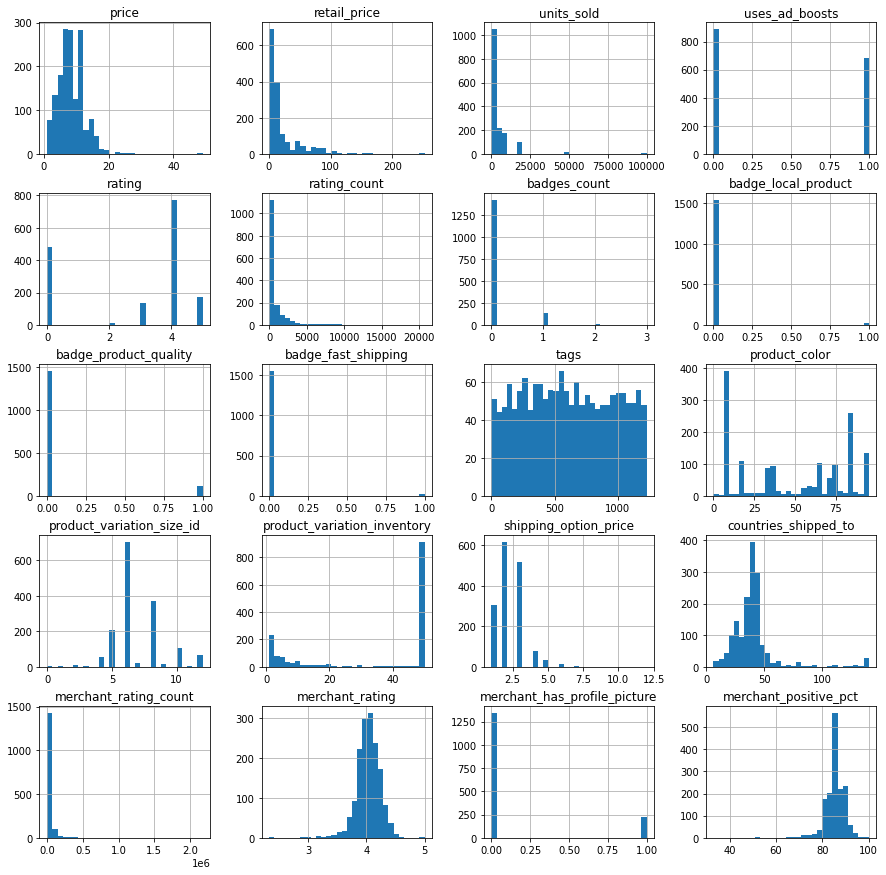

In [218]:
#plot the histogram for each column
%matplotlib inline
df_new.hist(bins=30, figsize=(15, 15))
plt.show()

**Observation:** Many columns seems to possess outliers.

 *2) Detection and Removal of Outliers from All Columns*

In [219]:
#Declaring Grubbs Test Function for Outlier Detection
def outlier_cols_ram(x): 
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    return col if (g_critical) < g_calculated else 0

In [220]:
#Finding all Columns with Outliers
cols_with_outliers = []
for col in df_new.columns:
    outlier_col = outlier_cols_ram(df_new[col])
    cols_with_outliers.append(outlier_col)

while (cols_with_outliers.count(0)):
    cols_with_outliers.remove(0)


cols_with_outliers

['price',
 'retail_price',
 'units_sold',
 'rating_count',
 'badges_count',
 'badge_local_product',
 'badge_fast_shipping',
 'shipping_option_price',
 'countries_shipped_to',
 'merchant_rating_count',
 'merchant_rating',
 'merchant_positive_pct']

**#Result:** Above columns possess outliers.

 *3) Removing Outliers from all the Columns (Performing Cubical Transformation)*

In [221]:
for col in cols_with_outliers:
    df_new[col] = (df_new[col]**(1/3.7))

*4) Verifying the Outlier removal from all the Columns*

In [222]:
any_outlier_col = []
for col in cols_with_outliers:
    outlier_col = outlier_cols_ram(df_new[col])
    any_outlier_col.append(outlier_col)

while (any_outlier_col.count(0)): 
    any_outlier_col.remove(0)

any_outlier_col

['price',
 'badge_local_product',
 'badge_fast_shipping',
 'shipping_option_price',
 'merchant_rating_count',
 'merchant_rating',
 'merchant_positive_pct']

**#Result:** The above columns still possess outliers.

*5) Individually removing outliers from 'any_outlier_col' columns*

In [223]:
#Declaring function for outlier detection.

def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier\n")
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")



*6.1) Removing Cubical Transform from Columns with Outliers*

In [224]:
for col in any_outlier_col:
    df_new[col] = (df_new[col]**(3.7))  

*6.2) Removing Outlier from 'price' Column (Using Imputing)*

In [225]:
df_new['price'].value_counts()

8.00     282
11.00    202
7.00     129
9.00     126
6.00     120
        ... 
4.94       1
1.84       1
4.74       1
3.74       1
1.71       1
Name: price, Length: 127, dtype: int64

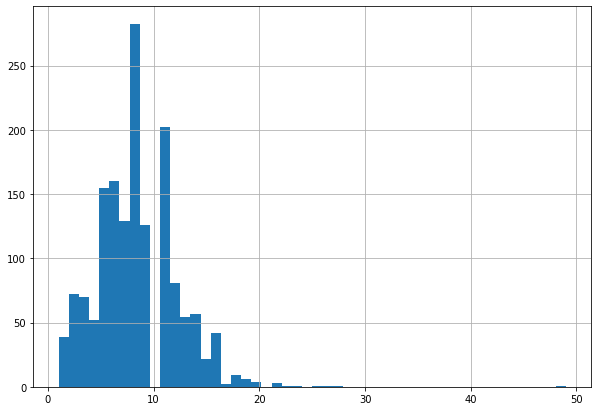

In [226]:
%matplotlib inline
df_new['price'].hist(bins = 50, figsize=(10,7)) 
plt.show()

In [227]:
for i in df_new['price']:
    if i >= 22:
        df_new['price'] = df_new['price'].replace(i, 22)
df_new['price'].value_counts()

8.00     282
11.00    202
7.00     129
9.00     126
6.00     120
        ... 
1.84       1
4.68       1
4.74       1
3.74       1
1.71       1
Name: price, Length: 122, dtype: int64

In [228]:
grubbs_test(df_new['price'])

Grubbs Calculated Value: 3.6331845571702077
Grubbs Critical Value: 4.149500059915179
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier



*6.3) Removing Outlier from 'merchant_rating' Column (Using Imputing)*

In [229]:
df_new['merchant_rating'].value_counts()

3.884544    15
4.045170    12
4.006692     9
3.867547     8
4.105967     8
            ..
3.937343     1
3.829268     1
4.109024     1
4.303985     1
4.056169     1
Name: merchant_rating, Length: 952, dtype: int64

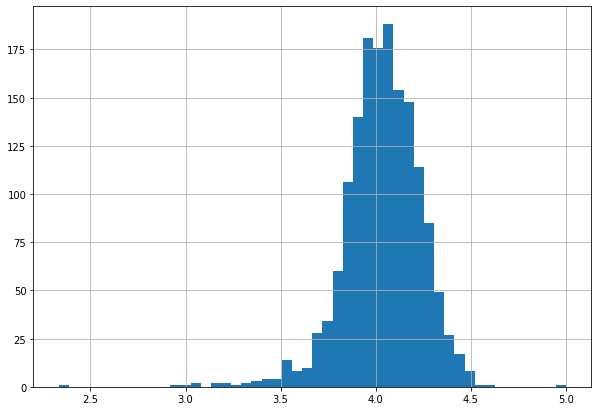

In [230]:
%matplotlib inline
df_new['merchant_rating'].hist(bins = 50, figsize=(10,7)) 
plt.show()

In [231]:
for i in df_new['merchant_rating']:
    if i <= 3.3:
        df_new['merchant_rating'] = df_new['merchant_rating'].replace(i, 3.3)
    if i >= 4.3:
        df_new['merchant_rating'] = df_new['merchant_rating'].replace(i, 4.4)
df_new['merchant_rating'].value_counts()

4.400000    114
3.884544     15
4.045170     12
3.300000     11
4.006692      9
           ... 
4.022944      1
4.226463      1
4.024055      1
4.020408      1
4.056169      1
Name: merchant_rating, Length: 854, dtype: int64

In [232]:
grubbs_test(df_new['merchant_rating'])

Grubbs Calculated Value: 3.715543077842438
Grubbs Critical Value: 4.149500059915179
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier



*6.4) Removing Outlier from ''shipping_option_price'' Column (Using Imputing)*

In [233]:
df_new['shipping_option_price'].value_counts()

2.0     619
3.0     520
1.0     308
4.0      76
5.0      32
6.0      12
7.0       5
12.0      1
Name: shipping_option_price, dtype: int64

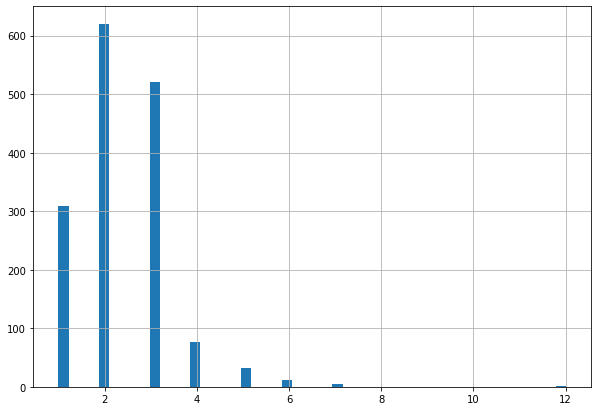

In [234]:
%matplotlib inline
df_new['shipping_option_price'].hist(bins = 50, figsize=(10,7)) 
plt.show()

In [235]:

for i in df_new['shipping_option_price']:
    if i >= 7:
        df_new['shipping_option_price'] = df_new['shipping_option_price'].replace(i, 6)
df_new['shipping_option_price'].value_counts()

2.0    619
3.0    520
1.0    308
4.0     76
5.0     32
6.0     12
6.0      6
Name: shipping_option_price, dtype: int64

In [236]:

grubbs_test(df_new['shipping_option_price'])

Grubbs Calculated Value: 3.7152322269929408
Grubbs Critical Value: 4.149500059915179
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier



*6.5) Removing Outlier from 'merchant_rating_count' Column (Using Imputing)*

In [237]:
df_new['merchant_rating_count'].value_counts()

32168.0    15
12309.0    12
80093.0     9
88193.0     8
10600.0     8
           ..
5807.0      1
8443.0      1
2212.0      1
8397.0      1
1086.0      1
Name: merchant_rating_count, Length: 917, dtype: int64

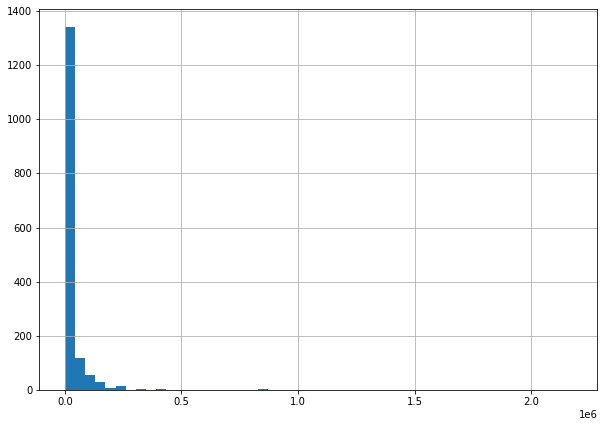

In [238]:
%matplotlib inline
df_new['merchant_rating_count'].hist(bins = 50, figsize=(10,7)) 
plt.show()

In [239]:
for i in df_new['merchant_rating_count']:
    if i >= 160000:
        df_new['merchant_rating_count'] = df_new['merchant_rating_count'].replace(i, 160000)
df_new['merchant_rating_count'].value_counts()

160000.0    36
32168.0     15
12309.0     12
80093.0      9
10600.0      8
            ..
343.0        1
8397.0       1
4955.0       1
1038.0       1
1086.0       1
Name: merchant_rating_count, Length: 898, dtype: int64

In [240]:
grubbs_test(df_new['merchant_rating_count'])

Grubbs Calculated Value: 3.9280013145950683
Grubbs Critical Value: 4.149500059915179
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier



*6.6) Removing Outlier from 'merchant_positive_pct' Column (Using Imputing)*

In [241]:
df_new['merchant_positive_pct'].value_counts()

85.410477     294
86.000000     141
85.000000     131
87.000000     113
88.000000     108
84.000000     105
83.000000      96
89.000000      95
82.000000      76
90.000000      71
91.000000      66
81.000000      58
80.000000      41
92.000000      32
79.000000      27
93.000000      24
94.000000      13
78.000000      10
77.000000      10
73.000000      10
95.000000      10
75.000000       9
76.000000       7
70.000000       4
71.000000       4
74.000000       3
65.000000       2
68.000000       2
53.000000       2
100.000000      2
97.000000       1
33.000000       1
56.000000       1
61.000000       1
59.000000       1
96.000000       1
67.000000       1
Name: merchant_positive_pct, dtype: int64

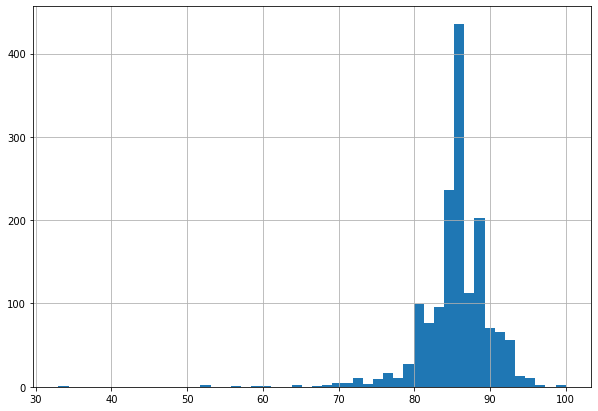

In [242]:
%matplotlib inline
df_new['merchant_positive_pct'].hist(bins = 50, figsize=(10,7)) 
plt.show()

In [243]:
for i in df_new['merchant_positive_pct']:
    if i <=70:
        df_new['merchant_positive_pct'] = df_new['merchant_positive_pct'].replace(i,70)
df_new['merchant_positive_pct'].value_counts()

85.410477     294
86.000000     141
85.000000     131
87.000000     113
88.000000     108
84.000000     105
83.000000      96
89.000000      95
82.000000      76
90.000000      71
91.000000      66
81.000000      58
80.000000      41
92.000000      32
79.000000      27
93.000000      24
70.000000      15
94.000000      13
78.000000      10
77.000000      10
95.000000      10
73.000000      10
75.000000       9
76.000000       7
71.000000       4
74.000000       3
100.000000      2
96.000000       1
97.000000       1
Name: merchant_positive_pct, dtype: int64

In [244]:
grubbs_test(df_new['merchant_positive_pct'])

Grubbs Calculated Value: 3.8512628924784624
Grubbs Critical Value: 4.149500059915179
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outlier



##**Data Normalization**

In [245]:
# Histogram show that the feilds like `rating_count`, `units_sold`, `retail_price` are
# highly skewed therefore taking their log to normalize the distribution.

def getLog(x):
    return np.log(x + 1)


df_new['rating_count']  = df_new['rating_count'].apply(getLog)
df_new['units_sold']  = df_new['units_sold'].apply(getLog)
df_new['retail_price']  = df_new['retail_price'].apply(getLog)

#**Split Train & Test files**

In [246]:
train_index = df1.shape[0]             #number of rows train_new dataset 
train_data_cleaned = df_new.iloc[:train_index]    
print(train_data_cleaned.shape)

test_data_cleaned = df_new.iloc[train_index :]
print(test_data_cleaned.shape)

test_data_cleaned.drop('rating', axis=1, inplace=True)
print(test_data_cleaned.shape)

(1094, 20)
(479, 20)
(479, 19)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#**Apply model on train file**

In [247]:
# splitting data to features and label(rating)
X_train = train_data_cleaned.drop('rating',axis=1)
y_train = train_data_cleaned['rating']

**Observations**

**Multinomial naive Bayes** assumes to have feature vector where each element represents the number of times it appears (or, very often, its frequency).*

**The Gaussian Naive Bayes,** instead, is based on a continuous distribution and it's suitable for more generic classification tasks.*

**The categorical Naive Bayes** is suitable for classification with discrete features that are categorically distributed. The categories of each feature are drawn from a categorical distribution.

**So** (The categorical Naive Bayes) is the best suitable solution for our problem, but let me try the 3 to make sure from ny knowledge.

In [248]:
#using different 3 objects from Naive bayes algorithm to train the model
GNB= MultinomialNB()   #Gaussian Naive Bayes
MNB= MultinomialNB()   # Multinomial Naive Bayes
CNB= CategoricalNB()   # Categorical Naive Bayes

#fitting the models on data
GNB.fit(X_train, y_train)
MNB.fit(X_train, y_train)
CNB.fit(X_train, y_train)

CategoricalNB()

In [249]:
#predict the output of the train file from the 3 models
y_GNB= GNB.predict(X_train)
y_MNB= MNB.predict(X_train)
y_CNB= CNB.predict(X_train)

*Gaussian*

In [250]:
#display the train accuracy
acc= accuracy_score(y_train,y_GNB)
print('Train Accuracy: ',acc,'\n')

#display the train f1 score
f1= f1_score(y_train, y_GNB, average='weighted')
print('Train f1 score: ',f1,'\n')

Train Accuracy:  0.26508226691042047 

Train f1 score:  0.3708000752371386 



*Multinominal*

In [251]:
#display the train accuracy
acc= accuracy_score(y_train,y_MNB)
print('Train Accuracy: ',acc,'\n')

#display the train f1 score
f1= f1_score(y_train, y_MNB, average='weighted')
print('Train f1 score: ',f1,'\n')

Train Accuracy:  0.26508226691042047 

Train f1 score:  0.3708000752371386 



*CategoricalNB*

In [252]:
#display the train accuracy
acc= accuracy_score(y_train,y_CNB)
print('Train Accuracy: ',acc,'\n')

#display the train f1 score
f1= f1_score(y_train, y_CNB, average='weighted')
print('Train f1 score: ',f1,'\n')

Train Accuracy:  0.8829981718464351 

Train f1 score:  0.8734250436092282 



**#Result** The categorical Naive Bayes is the best model out of the 3 models in our problem.

#**Apply model on test file**

In [253]:
#predict the output of the test file & saving it in csv file called('pred_walkthrough)
sample=pd.read_csv('/content/sample_submission_new.csv')
sample['id']

pred_test = CNB.predict(test_data_cleaned)
pred_df = pd.DataFrame(data={'id': np.asarray( sample['id']), 'rating': pred_test})
pred_df.to_csv('pred_walkthrough.csv', index=False)

In [254]:
y_pred= pd.DataFrame(np.array(pred_test))
y_pred.value_counts()

4.0    388
5.0     51
3.0     40
dtype: int64

#**Hint**

* Naive Bayes algorithm is NOT affected by feature magnitude, hence Naive Bayes does not need feature scaling.